<a href="https://colab.research.google.com/github/ljm9748/deepstudy/blob/master/20_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print('gpu available : ', tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
gpu available :  True


In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 이미지 저장경로 만들기

In [0]:
import os
if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/deepstudy/assignment/4th week/gan_images"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/deepstudy/assignment/4th week/gan_images")

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# 생성자모델 만들기

128: 임의로 정한 노드수

Input_dim=100: 100차원 크기의 랜덤벡터 준비해 넣으라는 뜻 임의의 수!

7*7: 이미지의 최초크기

Upsampling2D(): 이미지의 가로세로길이 2배씩 늘려줌

Reshape(): 컨볼루션 레이어가 받아들일 수 있는 형태로 바꾸어주는 코드 Conv2D()함수의 input_shape에 들어갈 형태로 정하기

kernal_size가 3: 3x3 마스크

LeakyReLU(): 렐루에서 x값이 음수면 무조건 0이 되어 뉴런들이 일찍 소실되는 단점 보완위해 0이하에서도 작은 값을 갖게 만드는 활성화 함수 괄호안에 0.2를 넣으면 0보다 작을경우 0.2곱하라는 뜻

In [0]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자모델 만들기
Dropout(): 껏다켰다하면서 과적합 방지하는것

![대체 텍스트](https://lh3.googleusercontent.com/proxy/a4AWQFieQIoiEthN-gvQ6iPEACGqkP0ZoJron20w7De7jreHucQNhaSlnjp2gOfoHKTrqPGwhN4t8hy9-cdt6ZDqgS7ejKcXxTrqxjp0dat0rO8bC1LVGnGQAMp0M4u_grofbeVEaj0Y93T7dy0yxn3Lxsot6PkmzTP3ecpaCXyl8R8NGAM)

노드크기: 64, 128  커널크기:5-> 5x5마스크 적용

stride: 보폭으로 마스크 움직이는 단위 새로운 특징을 뽑고자 사용

생성자에서는 출력크기 28로 맞추고자 upsampling했지만 판별자는 진위여부구분만 의미있으므로 차원줄이는 stride나 dropout등 이용

flatten(): 2차원->1차원

discriminator.trainable = False: 판별자 자신이 학습되지 않게 하는것

In [0]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자, 판별자 모델 연결시키는 GAN모델 만들기

ginput = Input(shape=(100,)): 랜덤한 100개 벡터 케라스 Input()함수에 넣에 생성자에 입력할 ginput만드는과정

In [27]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


# 신경망 실행시키는 함수 만들기

savint_interval: 중간과정을 몇번에 한번씩 저장할지

 true = np.ones((batch_size, 1)): 실제 사진 불러왔으므로 모두 참(1) 넣음

 train_on_batch(x, y): 판별자모델에 함수써서 판별 시작하는데 x인 입력값, y의 레이블을 받아 딱 한번 실시해 모델 업데이트함. 만든이미지 x에 넣고 더 앞에서 만든 배열 y에 놓고 준비함

  fake = np.zeros((batch_size, 1)): 모두가짜라는 레이블 배치 사이즈만큼

  실제 이미지 넣은 d_loss_real과 가상이미지 입력한 d_loss_fake가 번갈아가며 진위 판단, 오차평균구한것이 d_loss

In [0]:
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  
  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  
  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))


  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("/content/gdrive/My Drive/Colab Notebooks/deepstudy/assignment/4th week/gan_images/gan_mnist_%d.png" % i)


epoch:0  d_loss:0.6792  g_loss:0.6492
epoch:1  d_loss:0.4773  g_loss:0.2935
epoch:2  d_loss:0.5510  g_loss:0.0954
epoch:3  d_loss:0.6334  g_loss:0.0916
epoch:4  d_loss:0.5778  g_loss:0.1699
epoch:5  d_loss:0.4966  g_loss:0.3841
epoch:6  d_loss:0.4985  g_loss:0.5205
epoch:7  d_loss:0.5252  g_loss:0.6132
epoch:8  d_loss:0.5295  g_loss:0.5679
epoch:9  d_loss:0.4789  g_loss:0.6057
epoch:10  d_loss:0.4796  g_loss:0.6061
epoch:11  d_loss:0.4761  g_loss:0.7001
epoch:12  d_loss:0.5052  g_loss:0.6472
epoch:13  d_loss:0.5019  g_loss:0.8679
epoch:14  d_loss:0.5352  g_loss:0.8797
epoch:15  d_loss:0.6787  g_loss:0.9248
epoch:16  d_loss:0.5671  g_loss:0.8141
epoch:17  d_loss:0.5497  g_loss:0.8938
epoch:18  d_loss:0.5014  g_loss:0.7088
epoch:19  d_loss:0.4654  g_loss:0.5572
epoch:20  d_loss:0.3806  g_loss:0.5412
epoch:21  d_loss:0.3510  g_loss:0.6954
epoch:22  d_loss:0.3567  g_loss:0.7675
epoch:23  d_loss:0.3345  g_loss:0.6255
epoch:24  d_loss:0.3308  g_loss:0.4626
epoch:25  d_loss:0.3014  g_loss:0.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


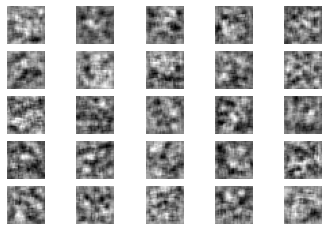

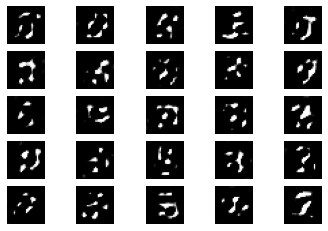

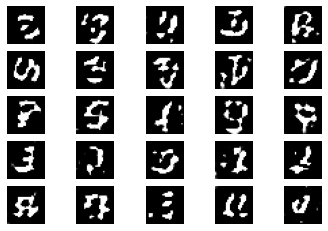

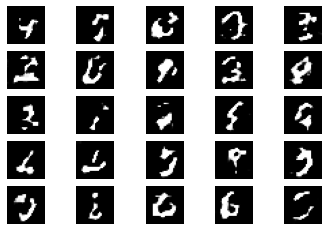

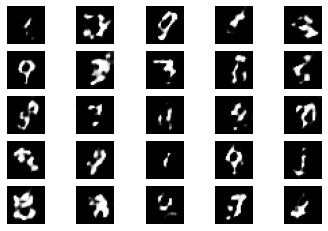

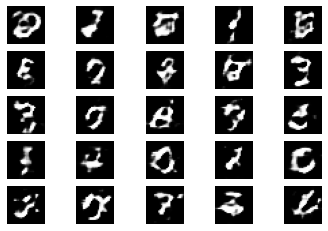

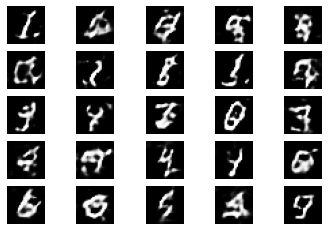

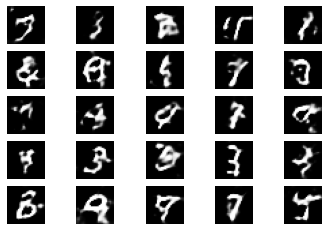

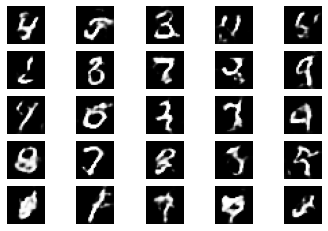

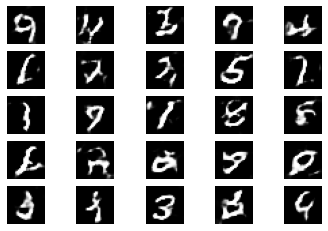

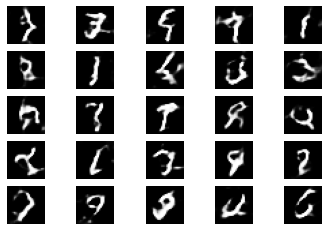

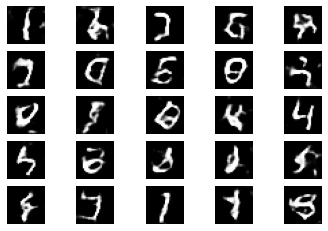

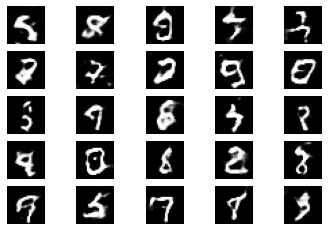

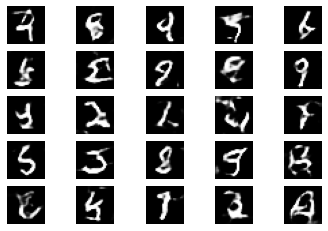

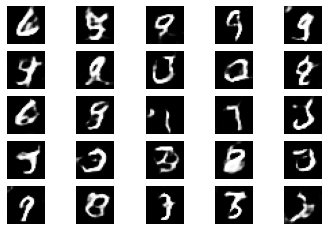

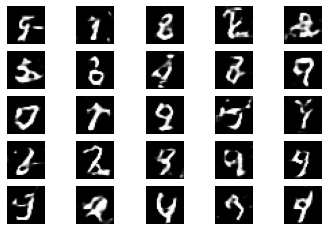

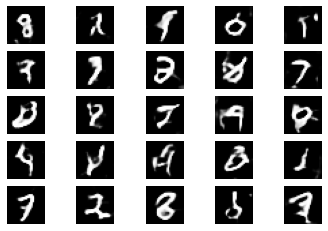

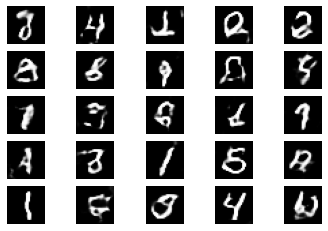

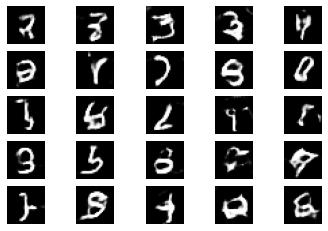

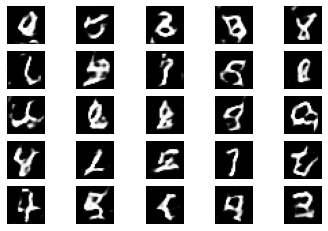

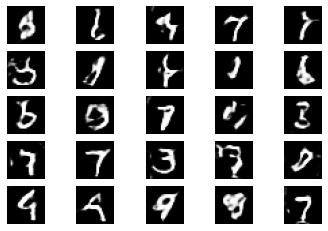

In [29]:
gan_train(4001, 32, 200)